In [1]:
library(tidyverse)
library(ape)
library(igraph)
library(sensiPhy)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘igraph’


The following objects are masked from ‘package:ape’:

    edges, mst, ring


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is ma

In [2]:
d <- read_csv("../data/data_cues.txt")


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Glottocode = col_character(),
  Language = col_character(),
  Genus = col_character(),
  Case_Marking = col_double(),
  Tight_Semantics = col_double(),
  Rigid_Order = col_double(),
  Verb_Middle = col_double()
)



In [3]:
head(d)

Glottocode,Language,Genus,Case_Marking,Tight_Semantics,Rigid_Order,Verb_Middle
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stan1318,Arabic,Semitic,0.036,0.218,0.655,0.391
bulg1262,Bulgarian,Slavic,0.028,0.144,0.782,0.966
croa1245,Croatian,Slavic,0.415,0.147,0.414,0.900
czec1258,Czech,Slavic,0.525,0.172,0.240,0.818
dani1285,Danish,Germanic,0.000,0.208,0.926,0.912
dutc1256,Dutch,Germanic,0.000,0.214,0.817,0.462


In [4]:
d %>%
    mutate(
        x1 = scale(Case_Marking), 
        x2 = scale(Tight_Semantics),
        x3 = scale(Rigid_Order),
        x4 = scale(Verb_Middle)
    ) -> d
head(d)

Glottocode,Language,Genus,Case_Marking,Tight_Semantics,Rigid_Order,Verb_Middle,x1,x2,x3,x4
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
stan1318,Arabic,Semitic,0.036,0.218,0.655,0.391,-0.7628649,0.826553846,0.09797316,-0.7625740
bulg1262,Bulgarian,Slavic,0.028,0.144,0.782,0.966,-0.7927616,-0.515764763,0.55542136,0.7687882
croa1245,Croatian,Slavic,0.415,0.147,0.414,0.900,0.6534927,-0.461346441,-0.77009783,0.5930144
czec1258,Czech,Slavic,0.525,0.172,0.240,0.818,1.0645728,-0.007860424,-1.39683789,0.3746289
dani1285,Danish,Germanic,0.000,0.208,0.926,0.912,-0.8974002,0.645159439,1.07410278,0.6249733
dutc1256,Dutch,Germanic,0.000,0.214,0.817,0.462,-0.8974002,0.753996083,0.68148976,-0.5734840


In [5]:
phylo <- read.tree("../data/posterior.tree")

In [6]:


d <- as.data.frame(d)
rownames(d) <- d$Language
head(d)

,Glottocode,Language,Genus,Case_Marking,Tight_Semantics,Rigid_Order,Verb_Middle,x1,x2,x3,x4
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
Arabic,stan1318,Arabic,Semitic,0.036,0.218,0.655,0.391,-0.7628649,0.826553846,0.09797316,-0.7625740
Bulgarian,bulg1262,Bulgarian,Slavic,0.028,0.144,0.782,0.966,-0.7927616,-0.515764763,0.55542136,0.7687882
Croatian,croa1245,Croatian,Slavic,0.415,0.147,0.414,0.900,0.6534927,-0.461346441,-0.77009783,0.5930144
Czech,czec1258,Czech,Slavic,0.525,0.172,0.240,0.818,1.0645728,-0.007860424,-1.39683789,0.3746289
Danish,dani1285,Danish,Germanic,0.000,0.208,0.926,0.912,-0.8974002,0.645159439,1.07410278,0.6249733
Dutch,dutc1256,Dutch,Germanic,0.000,0.214,0.817,0.462,-0.8974002,0.753996083,0.68148976,-0.5734840


### Running the PC algorithm by hand

In [11]:
checkIndependence <- function(iv, dv) {
    frm <- as.formula(
        str_c(c(dv, " ~ ", str_c(iv, collapse=" + ")), collapse="")
    )
    fit <- tree_phylm(frm, data=d, phy=phylo, n.tree=1000, model="BM")
    return(fit)
}

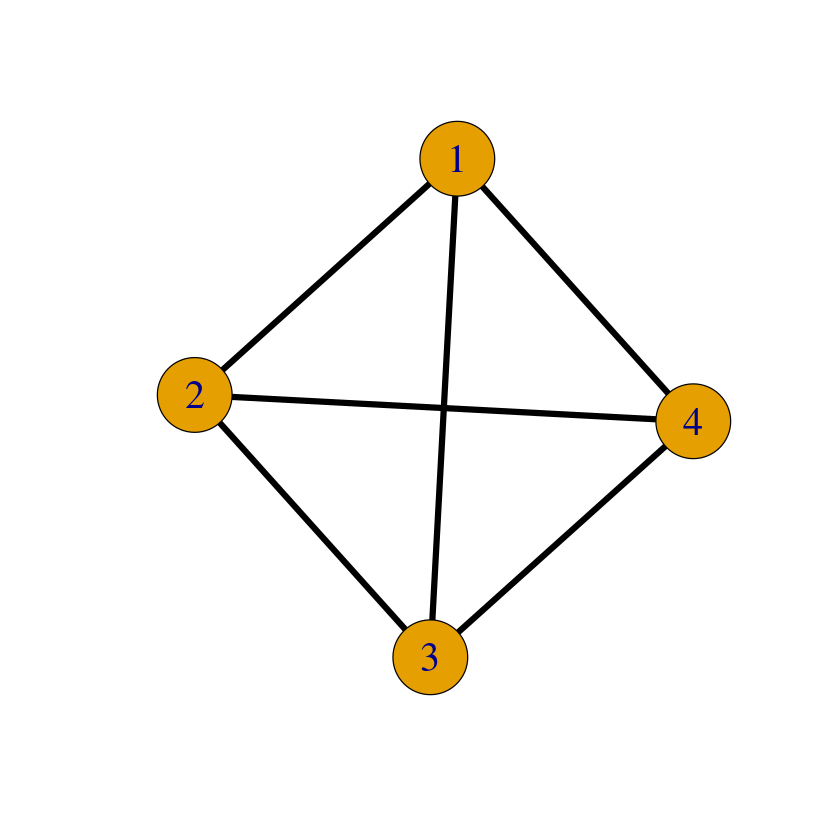

In [13]:
g <- make_full_graph(4)
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [12]:
iv = "x1"
dv = "x2"
checkIndependence(iv, dv) %>% summary

Used dataset has  30  species that match data and phylogeny



  |======================================================================| 100%


,mean,CI_low,CI_high
,<dbl>,<dbl>,<dbl>
intercept,0.036,0.033,0.039
se.intercept,0.503,0.500,0.506
pval.intercept,0.929,0.926,0.933
estimate,0.276,0.274,0.278
se.estimate,0.211,0.210,0.211
pval.estimate,0.207,0.203,0.211


In [14]:
E(g)

+ 6/6 edges from 5338057:
[1] 1--2 1--3 1--4 2--3 2--4 3--4

In [15]:
g <- delete_edges(g, 1)

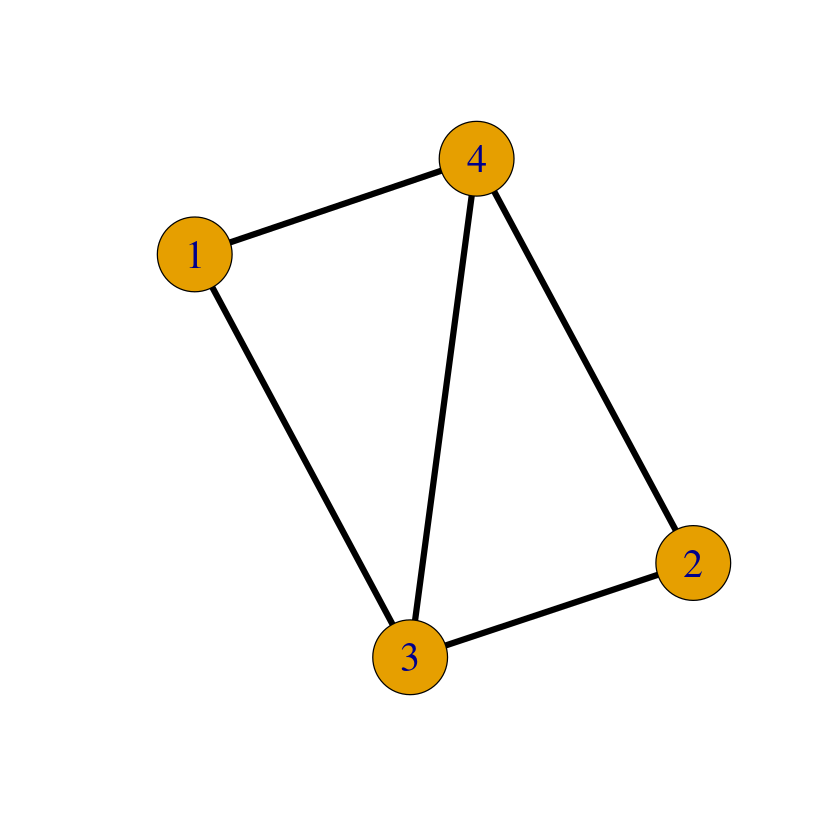

In [16]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [17]:
dv <- "x1"
iv <- c("x3")
checkIndependence(iv, dv) %>% summary

Used dataset has  30  species that match data and phylogeny



  |======================================================================| 100%


,mean,CI_low,CI_high
,<dbl>,<dbl>,<dbl>
intercept,0.033,0.029,0.037
se.intercept,0.288,0.286,0.289
pval.intercept,0.852,0.845,0.859
estimate,-0.816,-0.819,-0.814
se.estimate,0.127,0.127,0.128
pval.estimate,0.000,0.000,0.000


In [18]:
dv <- "x1"
iv <- c("x4")
checkIndependence(iv, dv) %>% summary

Used dataset has  30  species that match data and phylogeny



  |======================================================================| 100%


,mean,CI_low,CI_high
,<dbl>,<dbl>,<dbl>
intercept,-0.156,-0.161,-0.152
se.intercept,0.436,0.433,0.439
pval.intercept,0.726,0.719,0.732
estimate,-0.448,-0.452,-0.445
se.estimate,0.216,0.215,0.217
pval.estimate,0.051,0.050,0.052


In [19]:
E(g)

+ 5/5 edges from dfff283:
[1] 1--3 1--4 2--3 2--4 3--4

In [20]:
g <- delete_edges(g, 2)

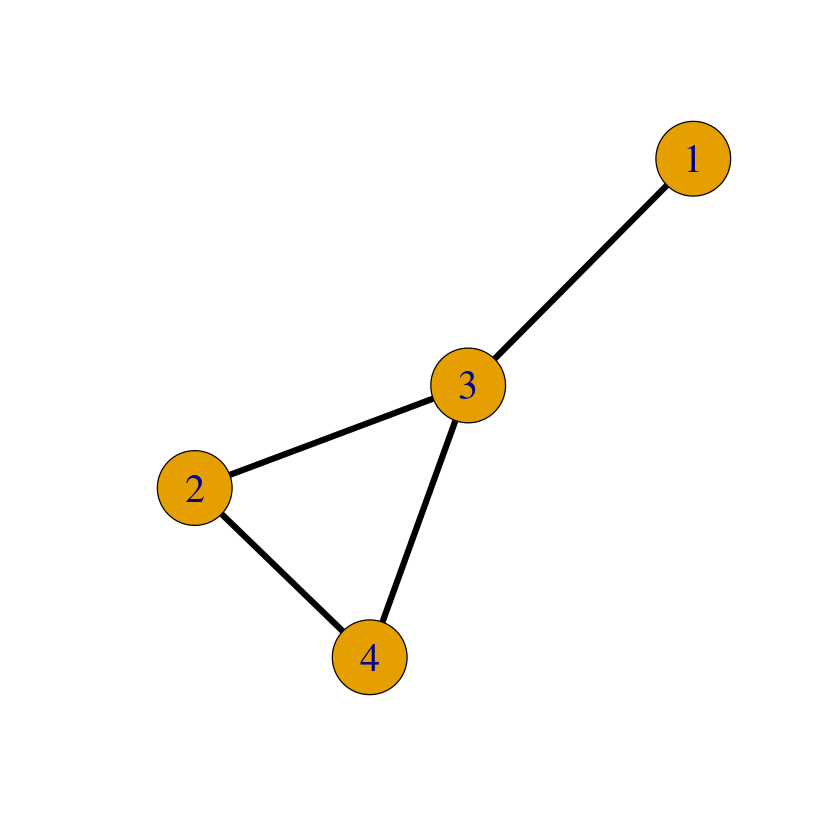

In [21]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [22]:
dv <- "x2"
iv <- c("x3")
checkIndependence(iv, dv) %>% summary

Used dataset has  30  species that match data and phylogeny



  |======================================================================| 100%


,mean,CI_low,CI_high
,<dbl>,<dbl>,<dbl>
intercept,0.049,0.045,0.052
se.intercept,0.514,0.511,0.517
pval.intercept,0.911,0.907,0.915
estimate,-0.167,-0.169,-0.165
se.estimate,0.228,0.227,0.228
pval.estimate,0.473,0.467,0.479


In [23]:
E(g)

+ 4/4 edges from 1e8f26b:
[1] 1--3 2--3 2--4 3--4

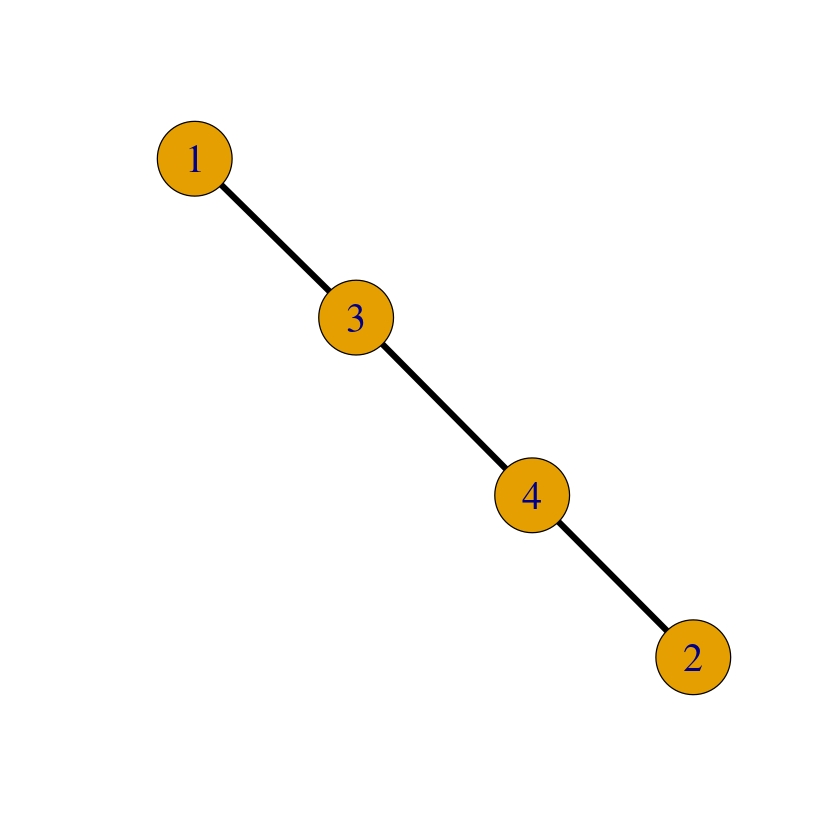

In [24]:
g <- delete_edges(g, 2)
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [25]:
dv <- "x2"
iv <- c("x4")
checkIndependence(iv, dv) %>% summary

Used dataset has  30  species that match data and phylogeny



  |======================================================================| 100%


,mean,CI_low,CI_high
,<dbl>,<dbl>,<dbl>
intercept,-0.182,-0.186,-0.179
se.intercept,0.508,0.505,0.511
pval.intercept,0.723,0.718,0.728
estimate,-0.457,-0.459,-0.455
se.estimate,0.252,0.251,0.252
pval.estimate,0.084,0.082,0.085


In [26]:
E(g)

+ 3/3 edges from 12b84a6:
[1] 1--3 2--4 3--4

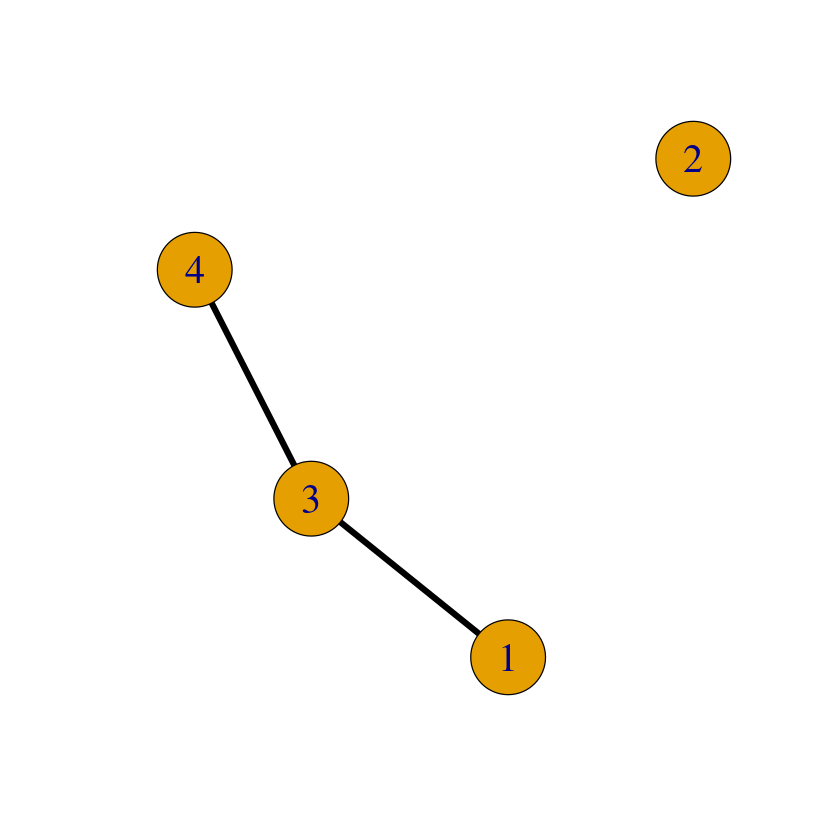

In [27]:
g <- delete_edges(g, 2)
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [28]:
dv <- "x3"
iv <- c("x4")
checkIndependence(iv, dv) %>% summary

Used dataset has  30  species that match data and phylogeny



  |======================================================================| 100%


,mean,CI_low,CI_high
,<dbl>,<dbl>,<dbl>
intercept,0.158,0.152,0.164
se.intercept,0.414,0.411,0.416
pval.intercept,0.713,0.704,0.722
estimate,0.408,0.406,0.411
se.estimate,0.205,0.204,0.206
pval.estimate,0.060,0.058,0.061


In [29]:
E(g)

+ 2/2 edges from b1dc120:
[1] 1--3 3--4

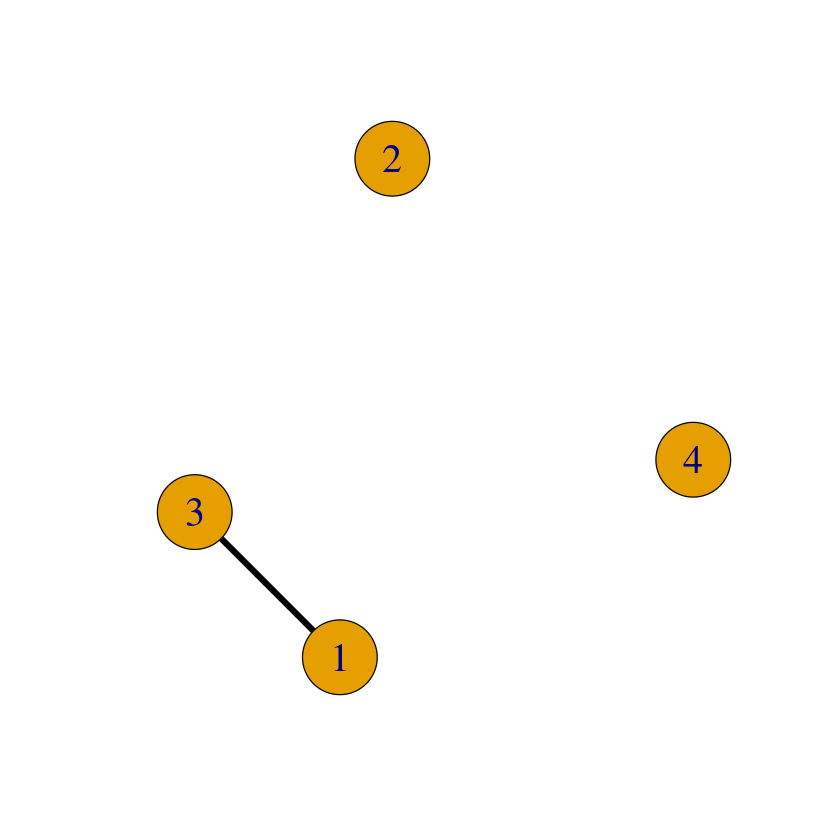

In [30]:
g <- delete_edges(g, 2)
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)